In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('.'), '..')))

In [2]:
import numpy as np

from keras.applications import VGG16
from keras.applications import VGG19
from keras.applications import Xception
from keras.applications import InceptionV3
from keras.applications import ResNet50
from keras.applications import MobileNetV2

from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

from keras import backend as K
from keras.models import load_model
from keras.layers import Input

from yolo_keras.utils import *
from yolo_keras.model import *
from PIL import Image
import matplotlib.pyplot as plt

import argparse
import logging
from numpy import asarray


def detect_objects(image, boxes, scores, classes, yolo_model, input_image_shape):
    
    # normalize and reshape image data
    image_data = np.array(image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

    # Predict classes and locations using Tensorflow session
    sess = K.get_session()
    out_boxes, out_scores, out_classes = sess.run(
                [boxes, scores, classes],
                feed_dict={
                    yolo_model.input: image_data,
                    input_image_shape: [image.size[1], image.size[0]],
                    K.learning_phase(): 0
                })
    return out_boxes, out_scores, out_classes


def open_model():
    anchors_path = "/faceml/yolo_keras/yolo_anchors.txt"
    classes_path = "/faceml/yolo_keras/coco_classes.txt"
    model_path="/faceml/yolo_keras/yolo.h5"

    # Get the anchor box coordinates for the model

    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)

    # Get the COCO classes on which the model was trained

    with open(classes_path) as f:
        class_names = f.readlines()
        class_names = [c.strip() for c in class_names] 

    # Create YOLO model
    #home = os.path.expanduser("~")
    #model_path = os.path.join(home, "yolo.h5")
    yolo_model = load_model(model_path, compile=False)

    # Generate output tensor targets for bounding box predictions
    # Predictions for individual objects are based on a detection probability threshold of 0.3
    # and an IoU threshold for non-max suppression of 0.45

    return class_names, anchors,  yolo_model


def getBoxAreas(objects, out_classes, classname, out_scores, out_boxes, image_area):
    areas = []
    for i in range(len(out_classes)):
        if (objects[i]==classname):
            box_height=(out_boxes[i][2]-out_boxes[i][0])
            box_width=(out_boxes[i][3]-out_boxes[i][1])
            box_area=box_width*box_height
            areas.append(box_area)
    return areas


def keras_load_image(imgfile):
    img = image.load_img(imgfile, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

Using TensorFlow backend.


In [3]:
def show_objects(image, out_boxes, out_scores, out_classes):
    import random
    from PIL import Image
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt

    %matplotlib inline 
    
    model_image_size = (416, 416)
    # Set up some display formatting
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    # Plot the image
    img = np.array(image)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    # Set up padding for boxes
    img_size = model_image_size[0]
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x

    # Use a random color for each class
    unique_labels = np.unique(out_classes)
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)

    # process each instance of each class that was found
    for i, c in reversed(list(enumerate(out_classes))):
        # Get the class name
        predicted_class = class_names[c]
        # Get the box coordinate and probability score for this instance
        box = out_boxes[i]
        score = out_scores[i]

        # Format the label to be added to the image for this instance
        label = '{} {:.2f}'.format(predicted_class, score)

        # Get the box coordinates
        top, left, bottom, right = box
        y1 = max(0, np.floor(top + 0.5).astype('int32'))
        x1 = max(0, np.floor(left + 0.5).astype('int32'))
        y2 = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        x2 = min(image.size[0], np.floor(right + 0.5).astype('int32'))

        # Set the box dimensions
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        
        # Add a box with the color for this class
        color = bbox_colors[int(np.where(unique_labels == c)[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=label, color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
        
    plt.axis('off')
    plt.show()

In [4]:

def processImage(classname, imgfile, boxes, scores, classes,yolo_model, class_names, input_image_shape):
    image = Image.open(imgfile)
    model_image_size = (416, 416)
    image = letterbox_image(image, tuple(reversed(model_image_size)))
    iw, ih = image.size
    image_area=iw*ih

    out_boxes, out_scores, out_classes = detect_objects(image, boxes, scores, classes,yolo_model,input_image_shape)
    objects=[class_names[out_classes[i]] for i in range(len(out_classes))]
    if (classname in objects):
        img_areas = getBoxAreas(objects, out_classes, classname, out_scores, out_boxes, image_area)
        #load image for vgg
        img_x = keras_load_image(imgfile)
        return img_areas, img_x, out_boxes, out_scores, out_classes

    return None, None, out_boxes, out_scores, out_classes

def compareImages(model, img_areas1, img_areas2, x):
    x=asarray(x)
    x = preprocess_input(x)
    features = model.predict(x)
    fshape = features.shape
    print(fshape)
    features_compress = features.reshape(2, fshape[1] * fshape[2] * fshape[3])
    cos_sim = cosine_similarity(features_compress)
    return cos_sim[0,1]

<Figure size 432x288 with 0 Axes>

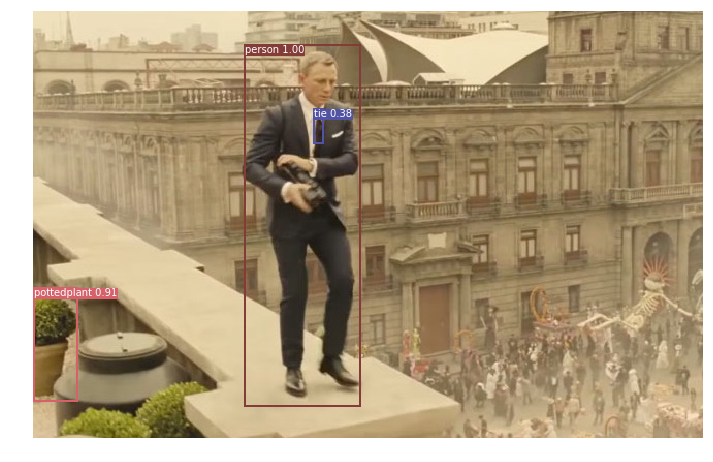

<Figure size 432x288 with 0 Axes>

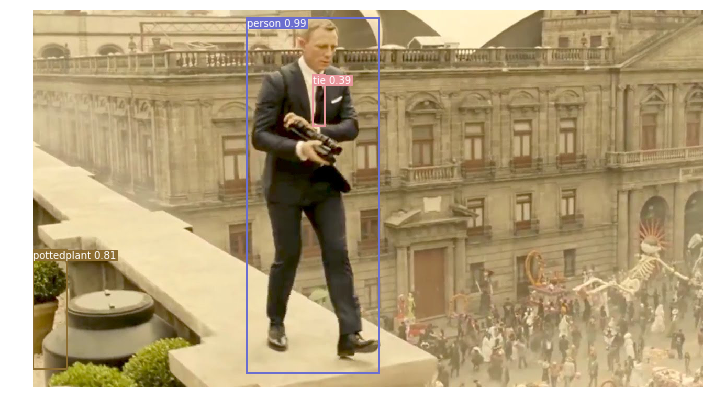

58892288/58889256 [==============================] - 54s 1us/step
(2, 7, 7, 512)
Similarity with model: VGG16 : 0.816096
80142336/80134624 [==============================] - 70s 1us/step
(2, 7, 7, 512)
Similarity with model: VGG19 : 0.793502
87916544/87910968 [==============================] - 90s 1us/step
(2, 5, 5, 2048)
Similarity with model: InceptionV3 : 0.830058
83689472/83683744 [==============================] - 90s 1us/step
(2, 7, 7, 2048)
Similarity with model: Xception : 0.793173


/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 121s 1us/step
(2, 7, 7, 2048)
Similarity with model: ResNet50 : 0.743909


/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:306: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


9412608/9406464 [==============================] - 10s 1us/step
(2, 7, 7, 1280)
Similarity with model: MobileNetV2 : 0.703864


In [5]:
image1="/faceml/sampleimages/craig2.jpg"
image2="/faceml/sampleimages/craig3.jpg"

#try with few models
MODELS={
"VGG16": VGG16,
"VGG19": VGG19,
"InceptionV3": InceptionV3,
"Xception": Xception,
"ResNet50": ResNet50,
"MobileNetV2": MobileNetV2
}
# Set the expected image size for the model
class_names, anchors, yolo_model = open_model()
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(yolo_model.output, anchors, len(class_names), input_image_shape,
                                    score_threshold=0.3, iou_threshold=0.45)
areas1, x1,out_boxes, out_scores, out_classes = processImage("person", image1, boxes, scores, classes,yolo_model, class_names, input_image_shape)
show_objects(Image.open(image1), out_boxes, out_scores, out_classes)

areas2, x2,out_boxes, out_scores, out_classes = processImage("person", image2, boxes, scores, classes,yolo_model, class_names, input_image_shape)
show_objects(Image.open(image2), out_boxes, out_scores, out_classes)

isSimilar=False
if not (areas1 is None or areas2 is None):
    for m in MODELS:
        model = MODELS[m](weights='imagenet', include_top=False) 
        sim = compareImages(model, areas1, areas2, [x1[0,:], x2[0,:]])
        print("Similarity with model:", m, ":", sim)